In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bz2
import re
import zipfile
import os
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_file_path = '/content/drive/MyDrive/deep_fake.zip'
destination_directory = '/content/deep_fake'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_directory)

# Print confirmation message
print("Unzipping complete!")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Unzipping complete!
cuda


In [ ]:
from torchvision import datasets, transforms
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
dataset = datasets.ImageFolder(root="/content/deep_fake/Dataset/Train", transform=data_transform)


In [ ]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numeric values (0 or 1)
encoded_labels = label_encoder.fit_transform(dataset.classes)

# Print the encoded labels
print(encoded_labels)

[0 1]


In [ ]:
from torch.utils.data import Subset

# Separate samples by class
real_samples = [idx for idx, (image, label) in enumerate(dataset.samples) if dataset.classes[label] == "Real"]
fake_samples = [idx for idx, (image, label) in enumerate(dataset.samples) if dataset.classes[label] == "Fake"]

# Randomly sample 20,000 samples from each class
real_samples = np.random.choice(real_samples, 25000, replace=False)
fake_samples = np.random.choice(fake_samples, 25000, replace=False)

# Combine the sampled indices
filtered_indices = np.concatenate([real_samples, fake_samples])
filtered_samples = [dataset.samples[idx] for idx in filtered_indices]

# Create a Subset dataset using the filtered samples
filtered_dataset = Subset(dataset, filtered_indices)

In [ ]:
dataset = filtered_dataset
# Define sizes for train, validation, and test sets
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset into train, validation, and test sets
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])
vali_size = int(0.11112*len(train_set))
train_size = len(train_set) - vali_size
train_set, vali_set = torch.utils.data.random_split(train_set, [train_size, vali_size])

# Create DataLoader for train, validation, and test sets
train_loader = DataLoader(train_set, batch_size=32,shuffle=True)
vali_loader = DataLoader(vali_set, batch_size=32,shuffle=True)
test_loader = DataLoader(test_set, batch_size=32,shuffle=True)

In [ ]:

class DepthWiseSeparable(nn.Module):
    def __init__(self, channels, middle_flow= False):
        super(DepthWiseSeparable, self).__init__()

        # block for entry flow
        if middle_flow== False:

            self.block= nn.Sequential(
                nn.ReLU(),
                nn.Conv2d(channels[0], channels[0],3, groups=channels[0], padding=1),
                nn.Conv2d(channels[0], channels[1],1),
                nn.BatchNorm2d( channels[1]),
                nn.ReLU(),
                nn.Conv2d( channels[1], channels[1],3, groups=channels[1], padding=1),
                nn.Conv2d( channels[1], channels[1],1),
                nn.BatchNorm2d(channels[1]),
                nn.MaxPool2d(3,stride=2, padding=1),
            )

        # block for middle flow
        if middle_flow==True:
            self.block= nn.Sequential(
                nn.ReLU(),
                nn.Conv2d(channels[0], channels[0],3, groups=channels[0], padding=1),
                nn.Conv2d(channels[0], channels[1],1),
                nn.BatchNorm2d( channels[1]),
                nn.ReLU(),
                nn.Conv2d( channels[1], channels[1],3, groups=channels[1], padding=1),
                nn.Conv2d( channels[1], channels[1],1),
                nn.BatchNorm2d(channels[1]),
                nn.ReLU(),
                nn.Conv2d( channels[1], channels[1],3, groups=channels[1], padding=1),
                nn.Conv2d( channels[1], channels[1],1),
            )

        # block for exit flow

        if middle_flow=='Exit':
            self.block= nn.Sequential(
                nn.Conv2d(channels[0], channels[0],3, groups=channels[0], padding=1),
                nn.Conv2d(channels[0], channels[1],1),
                nn.BatchNorm2d( channels[1]),
                nn.ReLU(),
                nn.Conv2d( channels[1], channels[1],3, groups=channels[1], padding=1),
                nn.Conv2d( channels[1], channels[2],1),
                nn.BatchNorm2d(channels[2]),
                nn.ReLU(),
            )



    def forward(self,x):
        x= self.block(x)
        return x


class Xception(nn.Module):
    def __init__(self, DepthWiseSeparable):
        super(Xception, self).__init__()

        self.conv1_3x3 = nn.Conv2d(3,32,3,stride=2,padding=1)
        self.bn1 =nn.BatchNorm2d(32)
        self.relu = nn.ReLU()

        self.conv2_3x3= nn.Conv2d(32,64,3,stride=1,padding=1)
        self.bn2 =nn.BatchNorm2d(64)
        self.relu= nn.ReLU()
        #Entry flow
        self.block_3x3= DepthWiseSeparable(channels=[64,128])
        self.downsample_1= nn.Conv2d(64,128,1,stride=2)

        self.block_3x3_256= DepthWiseSeparable(channels=[128,256])
        self.downsample_2= nn.Conv2d(128,256,1,stride=2)

        self.block_3x3_728= DepthWiseSeparable(channels=[256,728])
        self.downsample_3= nn.Conv2d(256,728,1,stride=2)
        #Middle Flow
        self.block_3x3_middle= DepthWiseSeparable(channels=[728,728], middle_flow=True)
        #Exit flow
        self.block_3x3_exit = DepthWiseSeparable(channels=[728,1024])
        self.downsample_4= nn.Conv2d(728,1024,1,stride=2)

        self.block_3x3_exit_2 = DepthWiseSeparable(channels=[1024,1536,2048], middle_flow='Exit')

        self.avgpool= nn.AdaptiveAvgPool2d((1,1))

        self.fc= nn.Linear(2048,1)

    def forward(self,x):
        x= self.relu(self.bn1(self.conv1_3x3(x)))
        x_identity = self.relu(self.bn2(self.conv2_3x3(x)))
        x_res_1= self.block_3x3(x_identity)
        x_identity= self.downsample_1(x_identity)
        x_identity= x_identity+x_res_1

        x_res_2= self.block_3x3_256(x_identity)
        x_identity= self.downsample_2(x_identity)

        x_identity= x_identity+x_res_2

        x_res_3= self.block_3x3_728(x_identity)
        x_identity= self.downsample_3(x_identity)
        x_identity= x_identity+x_res_3

        for i in range(9):
            x_res_4= self.block_3x3_middle(x_identity)
            x_identity= x_identity+x_res_4


        x_res_5= self.block_3x3_exit(x_identity)
        x_identity= self.downsample_4(x_identity)

        x_identity= x_identity+x_res_5

        x_res_6= self.block_3x3_exit_2(x_identity)

        x= self.avgpool(x_res_6)

        x= x.view(x.shape[0],-1)

        x= self.fc(x)

        return x
net= Xception(DepthWiseSeparable)
net.to(device)

Xception(
  (conv1_3x3): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2_3x3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block_3x3): DepthWiseSeparable(
    (block): Sequential(
      (0): ReLU()
      (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
      (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU()
      (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
      (6): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): MaxPool2d(kernel_size=3, stride=2, padd

In [ ]:
def train_and_validate(model, train_loader, vali_loader, device, num_epochs):
    train_losses, train_accuracies = [], []
    validation_losses, validation_accuracies = [], []
    train_predictions = []
    vali_predictions = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_predicted_true = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.float().to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            predictions = torch.sigmoid(outputs)

            predictions[outputs > 0.5] = 1.0
            predictions[outputs <= 0.5] = 0.0
            for i in range(len(predictions)):
              if predictions[i] == labels[i]:
                train_predicted_true += 1
            # Convert sigmoid outputs to binary predictions
            total_train += labels.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_predicted_true*100 / len(train_set))

        # Validation
        model.eval()
        vali_loss = 0
        vali_predicted_true = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in vali_loader:
                inputs, labels = inputs.to(device),labels.float().to(device)
                outputs = model(inputs)
                vali_loss += criterion(outputs.squeeze(), labels).item()
                vali_predictions = torch.sigmoid(outputs)
                vali_predictions[outputs > 0.5] = 1.0
                vali_predictions[outputs <= 0.5] = 0.0
                for i in range(len(vali_predictions)):
                  if vali_predictions[i] == labels[i]:
                    vali_predicted_true += 1

                total_val += labels.size(0)

        vali_loss_epoch = vali_loss / len(vali_loader)
        vali_acc_epoch = vali_predicted_true*100 / len(vali_set)
        validation_losses.append(vali_loss_epoch)
        validation_accuracies.append(vali_acc_epoch)

        # Print stats
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.4f}")
        print(f"Validation Loss: {validation_losses[-1]:.4f}, Accuracy: {validation_accuracies[-1]:.4f}")

    return train_losses, train_accuracies, validation_losses, validation_accuracies


In [ ]:
import torch.optim as optim

# Choose the optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001)  # Adjust learning rate as needed

# Choose the criterion (loss function)
criterion = nn.BCEWithLogitsLoss()

train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(
    model=net,
    train_loader=train_loader,
    vali_loader=vali_loader,
    device=device,
    num_epochs=10)

Epoch 1/10
Training Loss: 0.6454, Accuracy: 55.8300
Validation Loss: 0.6013, Accuracy: 58.0800
Epoch 2/10
Training Loss: 0.5294, Accuracy: 70.7275
Validation Loss: 0.5020, Accuracy: 76.4800
Epoch 3/10
Training Loss: 0.3942, Accuracy: 80.8450
Validation Loss: 0.4140, Accuracy: 75.3600
Epoch 4/10
Training Loss: 0.2944, Accuracy: 86.7400
Validation Loss: 0.3542, Accuracy: 86.8600
Epoch 5/10
Training Loss: 0.2355, Accuracy: 89.7450
Validation Loss: 0.3079, Accuracy: 86.5400
Epoch 6/10
Training Loss: 0.1980, Accuracy: 91.4925
Validation Loss: 0.2910, Accuracy: 88.7200
Epoch 7/10
Training Loss: 0.1711, Accuracy: 92.7375
Validation Loss: 0.2686, Accuracy: 90.8000
Epoch 8/10
Training Loss: 0.1503, Accuracy: 93.7825
Validation Loss: 0.2568, Accuracy: 87.2600
Epoch 9/10
Training Loss: 0.1305, Accuracy: 94.5525
Validation Loss: 0.2473, Accuracy: 89.3000
Epoch 10/10
Training Loss: 0.1106, Accuracy: 95.4800
Validation Loss: 0.2980, Accuracy: 88.9200


In [ ]:
def test(model):
  correct_test = 0
  test_loss = 0
  total_test=0
  test_predictions = []
  labels_test_total = []
  test_predicted_true = 0
  with torch.no_grad():
    for inputs, labels_test in test_loader:
        inputs,labels_test = inputs.to(device), labels_test.float().to(device)
        test_output = model(inputs)
        loss = criterion(test_output.squeeze(), labels_test)
        test_loss += loss.item()
        predicted_test_classes = torch.sigmoid(test_output)
        predicted_test_classes_modified = predicted_test_classes.clone()
        predicted_test_classes_modified[test_output > 0.5] = 1.0
        predicted_test_classes_modified[test_output <= 0.5] = 0.0
        for i in range(len(predicted_test_classes_modified)):
          if predicted_test_classes_modified[i] == labels_test[i]:
            test_predicted_true += 1
        total_test += labels_test.size(0)
        test_predictions.extend(predicted_test_classes_modified)
        labels_test_total.extend(labels_test)

  test_loss = test_loss / len(test_loader)
  test_accuracy = 100 * test_predicted_true / len(test_set)

  print(f"Test Accuracy: {test_accuracy:.2f}%")
  print(f"Test Loss: {test_loss:.4f}")

  return labels_test_total, test_predictions, predicted_test_classes, test_loss, test_accuracy


In [ ]:
test_labels, test_predictions, predicted_test_classes, test_loss, test_accuracy = test(net)

Test Accuracy: 89.56%
Test Loss: 0.2962


In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import seaborn as sns

def metrics(labels_test_total, predicted_test_classes, test_probabilities, test_loss, train_losses, validation_losses, train_accuracies, validation_accuracies):

    # Move tensors to CPU and detach from the computation graph
    labels_test_cpu = [labels.cpu() for labels in labels_test_total]
    predicted_test_classes_cpu = [predictions.cpu() for predictions in predicted_test_classes]
    test_probabilities_cpu = test_probabilities.cpu().detach().numpy()
    test_loss_cpu = test_loss

    accuracy = accuracy_score(labels_test_cpu, predicted_test_classes_cpu)
    precision = precision_score(labels_test_cpu, predicted_test_classes_cpu, average='micro')
    recall = recall_score(labels_test_cpu, predicted_test_classes_cpu, average='micro')
    f1Score = f1_score(labels_test_cpu, predicted_test_classes_cpu, average='micro')
    classify_report = classification_report(labels_test_cpu, predicted_test_classes_cpu)

    # Print classification metrics
    print("Accuracy:", accuracy)
    print("precision_score: ", precision)
    print("recall_score: ", recall)
    print("f1_score: ", f1Score)
    print("Classification Report:")
    print(classify_report)

    # Plot loss and accuracy curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(validation_losses, label='Validation Loss')
    ax1.axhline(y=test_loss_cpu, color='r', linestyle='--', label='Test Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(train_accuracies, label='Training Accuracy')
    ax2.plot(validation_accuracies, label='Validation Accuracy')
    ax2.axhline(y=accuracy, color='r', linestyle='--', label='Test Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(labels_test_cpu, predicted_test_classes_cpu)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

Accuracy: 0.8956
precision_score:  0.8956
recall_score:  0.8956
f1_score:  0.8956
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.90      2497
         1.0       0.90      0.89      0.89      2503

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



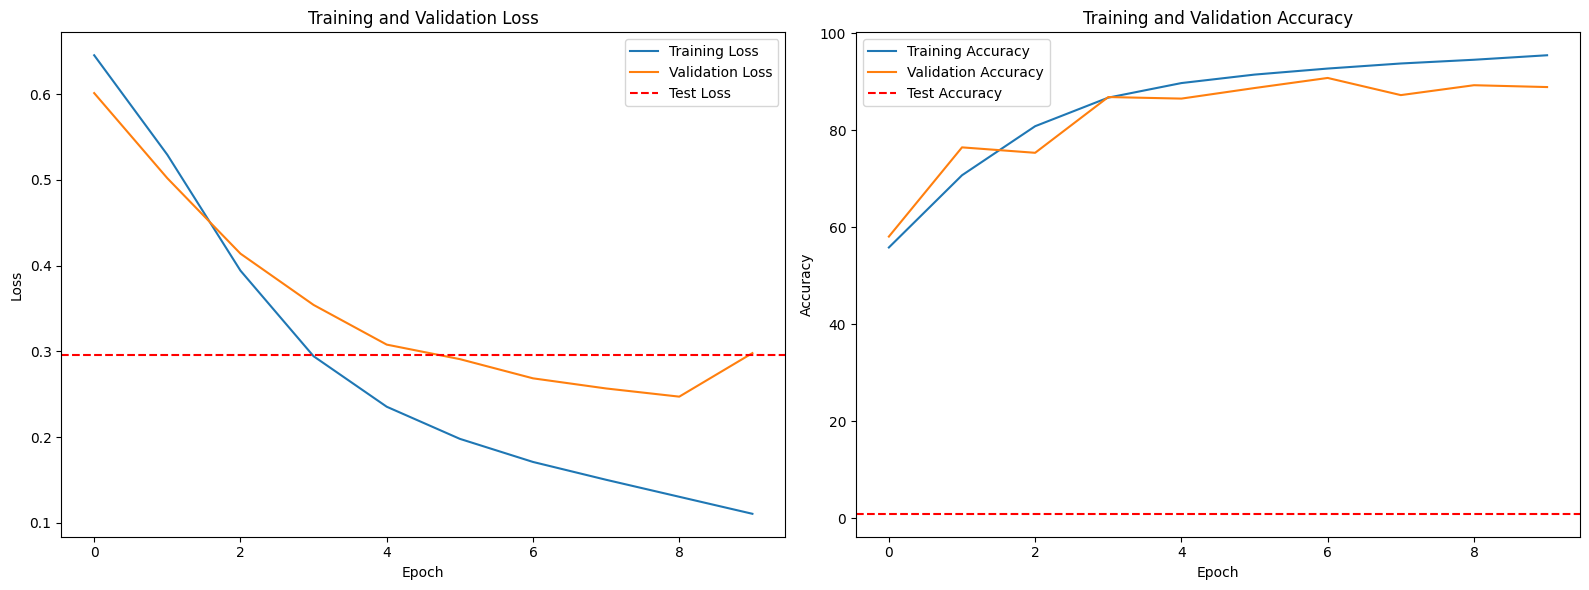

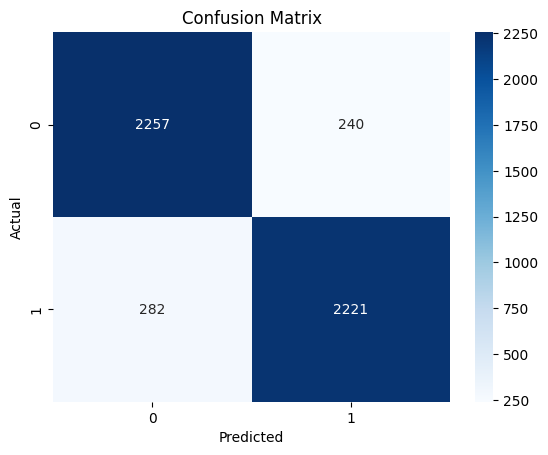

In [ ]:
metrics(test_labels, test_predictions, predicted_test_classes.cpu(), test_loss, train_losses, validation_losses, train_accuracies, validation_accuracies)

In [ ]:
def train_and_validate_1(model, train_loader, vali_loader, device, num_epochs, l2_shceduler, early_stopping=None,early_stop=False):
    train_losses, train_accuracies = [], []
    validation_losses, validation_accuracies = [], []
    train_predictions = []
    vali_predictions = []
    best_val_accuracy = 0
    l = 0
    epochs_completed = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_predicted_true = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.float().to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)

            if l2_shceduler:
              l2loss = 0.0
              for i in model.parameters():
                l2loss = l2loss + torch.norm(i)
              loss = loss + (l*l2loss)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            predictions = torch.sigmoid(outputs)

            predictions[outputs > 0.5] = 1.0
            predictions[outputs <= 0.5] = 0.0
            for i in range(len(predictions)):
              if predictions[i] == labels[i]:
                train_predicted_true += 1
            # Convert sigmoid outputs to binary predictions
            total_train += labels.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_predicted_true*100 / len(train_set))

        # Validation
        model.eval()
        vali_loss = 0
        vali_predicted_true = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in vali_loader:
                inputs, labels = inputs.to(device),labels.float().to(device)
                outputs = model(inputs)
                vali_loss += criterion(outputs.squeeze(), labels).item()
                vali_predictions = torch.sigmoid(outputs)
                vali_predictions[outputs > 0.5] = 1.0
                vali_predictions[outputs <= 0.5] = 0.0
                for i in range(len(vali_predictions)):
                  if vali_predictions[i] == labels[i]:
                    vali_predicted_true += 1

                total_val += labels.size(0)

        vali_loss_epoch = vali_loss / len(vali_loader)
        vali_acc_epoch = vali_predicted_true*100 / len(vali_set)
        validation_losses.append(vali_loss_epoch)
        validation_accuracies.append(vali_acc_epoch)

        if vali_acc_epoch > best_val_accuracy:
            best_val_accuracy = vali_acc_epoch
            epochs_completed = 0
        else:
            epochs_completed += 1

        if early_stop:
          if early_stopping and epochs_completed >= early_stopping:
              print(f'Early stopping triggered')
              early_stop = True
              break

        # Print stats
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.4f}")
        print(f"Validation Loss: {validation_losses[-1]:.4f}, Accuracy: {validation_accuracies[-1]:.4f}")

    return train_losses, train_accuracies, validation_losses, validation_accuracies


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model_1 = Xception(DepthWiseSeparable).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model_1.parameters(), lr=0.01, momentum=0.9)

cuda


In [ ]:
train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate_1(
    model=model_1,
    train_loader=train_loader,
    vali_loader=vali_loader,
    device=device,
    num_epochs=10,
    l2_shceduler=True)

Epoch 1/10
Training Loss: 0.3684, Accuracy: 82.2725
Validation Loss: 0.1771, Accuracy: 93.1800
Epoch 2/10
Training Loss: 0.1346, Accuracy: 94.2725
Validation Loss: 0.1810, Accuracy: 93.8600
Epoch 3/10
Training Loss: 0.0834, Accuracy: 96.4300
Validation Loss: 0.1528, Accuracy: 94.6400
Epoch 4/10
Training Loss: 0.0566, Accuracy: 97.5475
Validation Loss: 0.0855, Accuracy: 96.6200
Epoch 5/10
Training Loss: 0.0454, Accuracy: 97.9900
Validation Loss: 0.2092, Accuracy: 93.7800
Epoch 6/10
Training Loss: 0.0345, Accuracy: 98.4850
Validation Loss: 0.0734, Accuracy: 97.0800
Epoch 7/10
Training Loss: 0.0308, Accuracy: 98.6950
Validation Loss: 0.0899, Accuracy: 96.6400
Epoch 8/10
Training Loss: 0.0232, Accuracy: 99.0225
Validation Loss: 0.1192, Accuracy: 96.3600
Epoch 9/10
Training Loss: 0.0182, Accuracy: 99.2500
Validation Loss: 0.0963, Accuracy: 97.1400
Epoch 10/10
Training Loss: 0.0126, Accuracy: 99.4625
Validation Loss: 0.1043, Accuracy: 96.5800


In [ ]:
test_labels, test_predictions, predicted_test_classes, test_loss, test_accuracy = test(model_1)

Test Accuracy: 97.24%
Test Loss: 0.0889


Accuracy: 0.9724
precision_score:  0.9724
recall_score:  0.9724
f1_score:  0.9724
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97      2460
         1.0       0.97      0.98      0.97      2540

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000



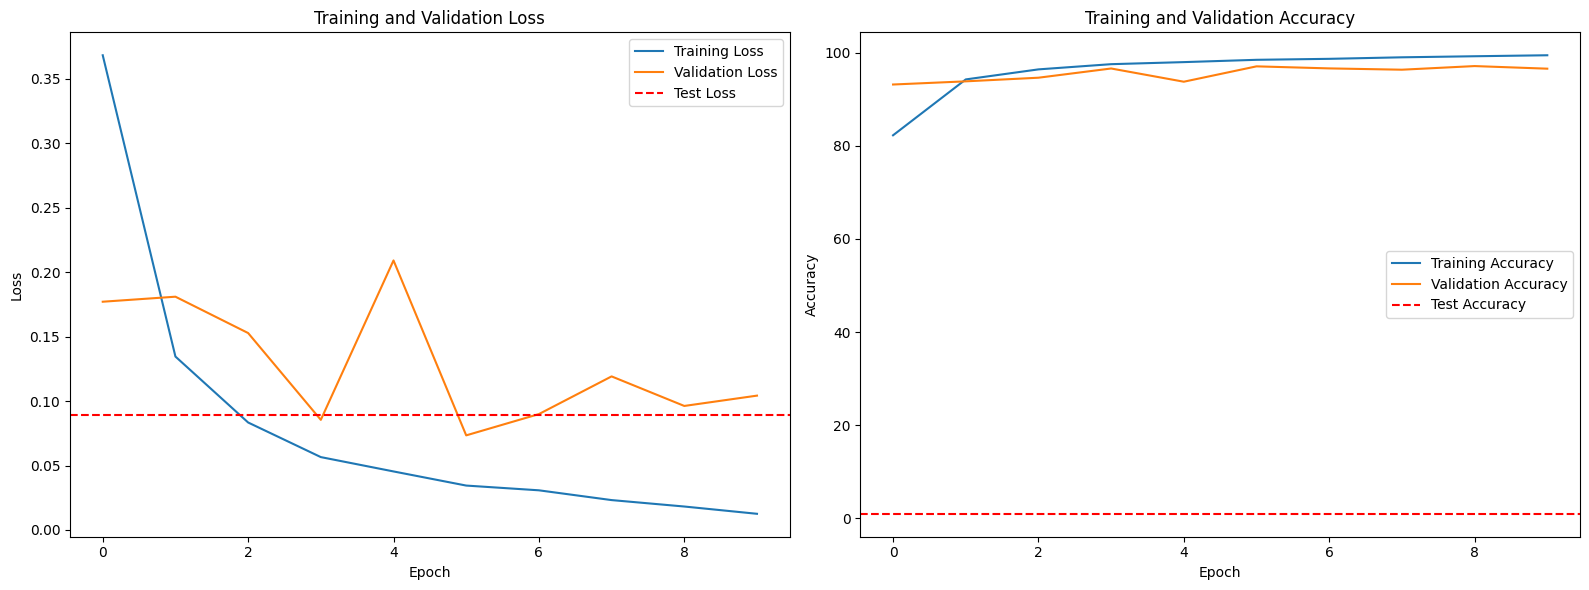

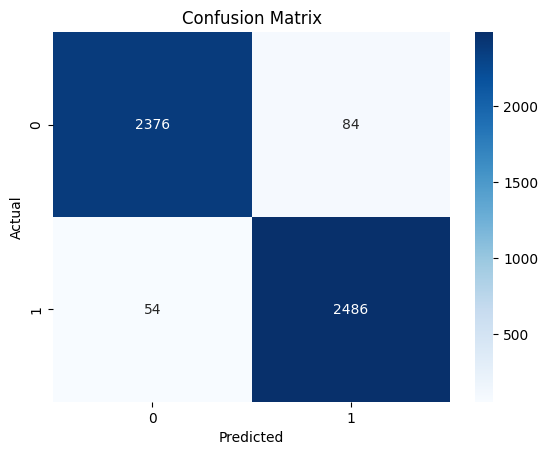

In [ ]:
metrics(test_labels, test_predictions, predicted_test_classes.cpu(), test_loss, train_losses, validation_losses, train_accuracies, validation_accuracies)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model_2 = Xception(DepthWiseSeparable).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model_2.parameters(), lr=0.01, momentum=0.9)

cuda


In [ ]:
train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate_1(
    model=model_2,
    train_loader=train_loader,
    vali_loader=vali_loader,
    device=device,
    num_epochs=10,
    l2_shceduler=True,
    early_stopping=4,early_stop=True)

Epoch 1/10
Training Loss: 0.3776, Accuracy: 81.7825
Validation Loss: 0.1661, Accuracy: 93.4800
Epoch 2/10
Training Loss: 0.1234, Accuracy: 94.7500
Validation Loss: 0.1149, Accuracy: 94.6200
Epoch 3/10
Training Loss: 0.0784, Accuracy: 96.6600
Validation Loss: 0.0940, Accuracy: 96.3400
Epoch 4/10
Training Loss: 0.0551, Accuracy: 97.6700
Validation Loss: 0.0844, Accuracy: 96.7800
Epoch 5/10
Training Loss: 0.0425, Accuracy: 98.2250
Validation Loss: 0.0823, Accuracy: 96.8200
Epoch 6/10
Training Loss: 0.0322, Accuracy: 98.6550
Validation Loss: 0.0819, Accuracy: 96.5800
Epoch 7/10
Training Loss: 0.0266, Accuracy: 98.8825
Validation Loss: 0.0787, Accuracy: 96.8000
Epoch 8/10
Training Loss: 0.0216, Accuracy: 99.0250
Validation Loss: 0.0856, Accuracy: 96.6000
Epoch 9/10
Training Loss: 0.0192, Accuracy: 99.2325
Validation Loss: 0.0778, Accuracy: 97.3000
Epoch 10/10
Training Loss: 0.0144, Accuracy: 99.4025
Validation Loss: 0.0876, Accuracy: 97.0800


In [ ]:
test_labels, test_predictions, predicted_test_classes, test_loss, test_accuracy = test(model_2)

Test Accuracy: 96.96%
Test Loss: 0.0884


Accuracy: 0.9696
precision_score:  0.9696
recall_score:  0.9696
f1_score:  0.9696
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      2460
         1.0       0.96      0.98      0.97      2540

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000



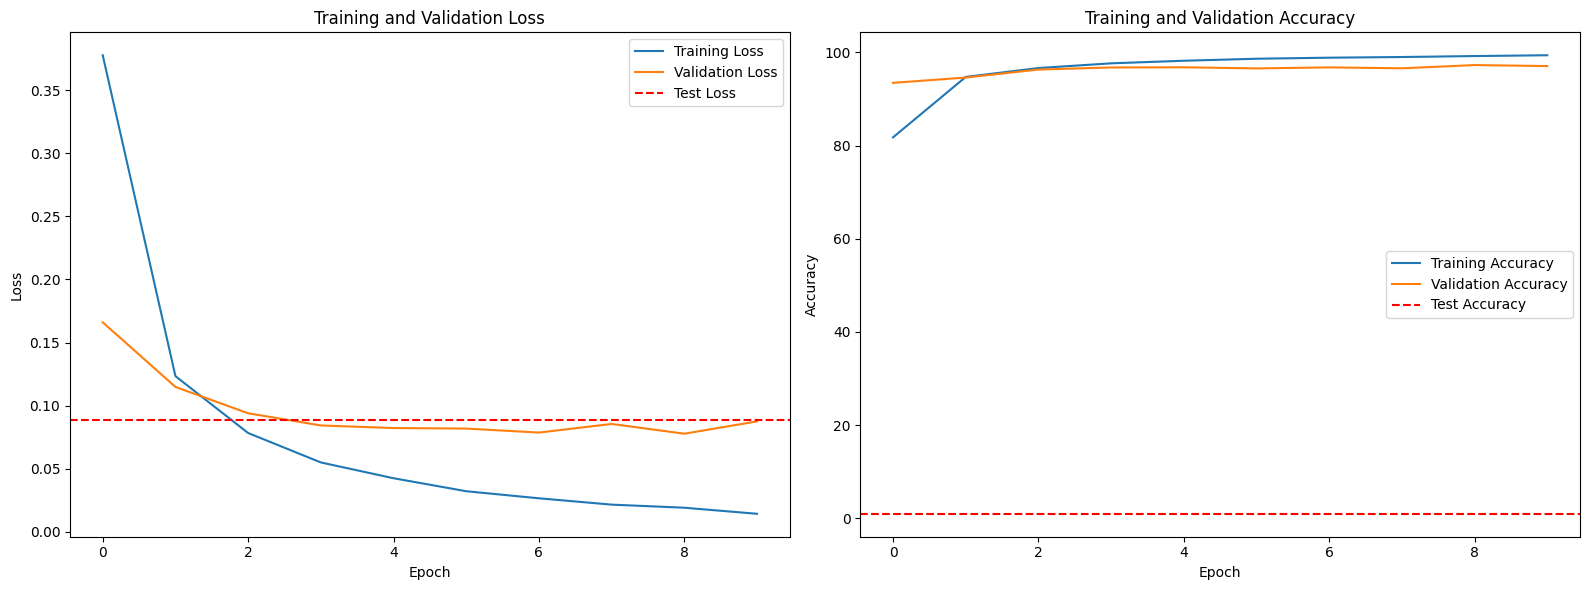

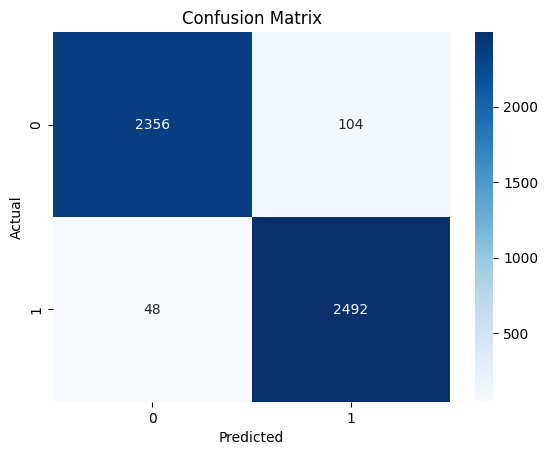

In [ ]:
metrics(test_labels, test_predictions, predicted_test_classes.cpu(), test_loss, train_losses, validation_losses, train_accuracies, validation_accuracies)